<a href="https://colab.research.google.com/github/jcdumlao14/ESS11DataAnalysis/blob/main/Principal_Component_Analysis(PCA)_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Principal Component Analysis(PCA + Clustering)**

## **Goal:** *Identify latent factors and groups of countries with similar-risk profiles.*

**Steps**

  1. Choose variables for factor/clustering (lifestyle + SES). Scale each variable.
  2. **Principal Component Analysis(PCA)**
     * Check correlations; run PCA (prcomp).
     * Retain factors: eigenvalues >1, scree, parallel analysis.
     * Rotation: oblique (e.g., oblimin/promax) if factors likely correlated.
     * Bootstrap factor loadings to get SDs and 90/95% CIs.
     * Save: scree plot, heatmap of loadings, table of loadings with CIs (tables/factor_loadings.csv).
  3. **Clustering**
     * Aggregate to country-level profiles (means or standardized medians) or cluster individuals with country label.
     * Methods: k-means + hierarchical, optionally latent profile analysis.
     * Choose k with silhouette, gap statistic, elbow. Bootstrap cluster stability.
     * Save: dendrogram, cluster map (countries colored), radar plots for cluster profiles, tables/clusters_summary.csv.






# **Variables Selection (Lifestyle + SES ):**
* **Lifestyle Variables**(again, check coding/direction):
  * **cgtsmok**: Cigarette smoking behaviour
  * **alcfreq**: How often drink alcohol
  * **etfruit**: How often eat fruit, excluding drinking juice
  * **eatveg**: How often eat vegetables or salad, excluding potatoes
  * **dosprt**: Do sports or other physical activity, how many of last 7 days
  - **slprl**: sleep was restless,how often past week

* **SES Variables**:
  - **edulvlb**: Highest level of education achieved (Handle carefully; ordinal, country-specific. See previous notes)
  - **hinctnta**: Household's total net income, all sources (Handle with care; lots of missing data likely; consider transforming (e.g. log) and imputation)
  - **agea**: Age of respondent, calculated (Numeric, or can be categorized into age groups)
  - **mainact**: Main activity last 7 days (employment).


## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# **Load the Dataset**

In [2]:
# Load the dataset
try:
    df = pd.read_csv('/content/ESS11.csv')
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Check '/content/ESS11.csv' path.")

# Convert columns to numeric, handling errors
cols_to_convert = ["hltprhc", "hltprhb", "hltphhc", "hltphhb"]
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric and coerce errors to NaN

# Impute missing values
df[cols_to_convert] = df[cols_to_convert].fillna(0)

# Add the new CVD column
df["CVD"] = df[["hltprhc", "hltprhb", "hltphhc", "hltphhb"]].sum(axis=1)

print("Step 1: update DataFrame 'hltprhc', 'hltprhb', 'hltphhc', 'hltphhb' to 'CVD'")


Step 1: update DataFrame 'hltprhc', 'hltprhb', 'hltphhc', 'hltphhb' to 'CVD'


# **Data cleaning & Required Cols**

In [3]:
# Data cleaning & required cols
key_cols = ['cntry','weighta', 'height', 'CVD', 'etfruit', 'eatveg', 'dosprt',
            'cgtsmok', 'slprl', 'agea', 'mainact', 'alcwkdy', 'alcwknd', 'edulvlb', 'hinctnta']
missing_cols = [c for c in key_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"The following required columns are missing from the dataframe: {missing_cols}")
df = df.dropna(subset=key_cols).copy()
print(f"Step 2: Dropped rows with NA in key columns. Remaining rows: {len(df)}")


Step 2: Dropped rows with NA in key columns. Remaining rows: 46162


## Convert height from cm to meters and compute BMI

In [4]:
# Convert height from cm to meters and compute BMI
df['height_m'] = df['height'] / 100.0
df['BMI'] = df['weighta'] / (df['height_m'] ** 2)
df = df[np.isfinite(df['BMI'])].copy()
print("Step 3: Calculated BMI and removed infinite values.")


Step 3: Calculated BMI and removed infinite values.


In [5]:
df.head().style.background_gradient(cmap='gist_rainbow')

## Ensure CVD is binary/int

In [6]:
# Ensure CVD is binary/int
if df['CVD'].dtype == object:
    df['CVD'] = df['CVD'].map(lambda x: 1 if str(x).lower() in ['1', 'yes', 'true', 'y', 't'] else 0)
    df['CVD'] = df['CVD'].astype(int)
    print(f"Unique values in Y (CVD): {np.unique(df['CVD'])}")


## Define X, T, Y

In [7]:
# Define X, T, Y
feature_cols = ['etfruit', 'eatveg', 'dosprt', 'cgtsmok',
                'slprl', 'agea', 'mainact', 'alcwkdy', 'alcwknd', 'edulvlb', 'hinctnta']
X = df[feature_cols].copy()
T = df['BMI'].copy()
Y = df['CVD'].copy()

## Scaling the data

In [8]:
# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# **PCA**

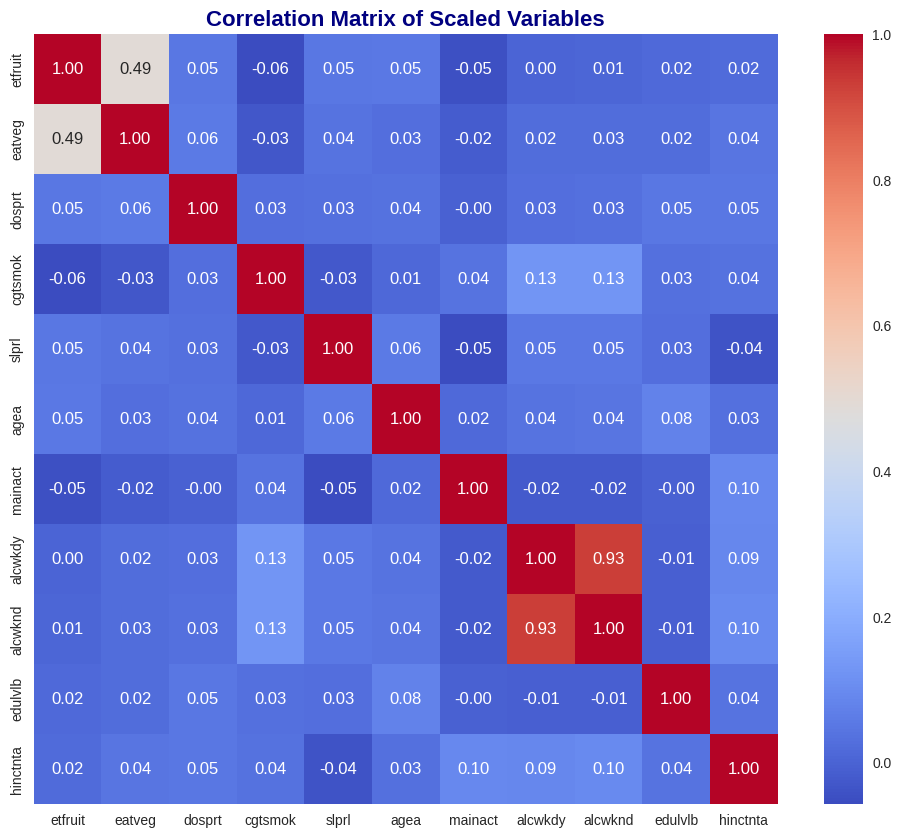

In [9]:
correlation_matrix = X_scaled_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Scaled Variables", fontsize=16, fontweight='bold', color='navy')
plt.savefig("correlation_matrix.png")  # Save the plot
plt.show()

**Key Observations and Interpretations**

1. **Strong Positive Correlations**:
   - **alcwkdy and alcwknd (0.93)**: There's a strong positive correlation between alcohol consumption on weekdays ("alcwkdy") and weekends ("alcwknd"). This indicates that individuals who tend to drink more on weekdays also tend to drink more on weekends, or vice-versa. This is intuitive.
   - **etfruit and eatveg (0.49)**: There is a notable positive correlation between eating fruit and eating vegetables. This suggests that individuals who eat more fruit also tend to eat more vegetables.
2. **Weak Correlations (Close to Zero)**:
   - Most of the other variable pairs exhibit weak correlations, meaning they have minimal linear relationship. This does not necessarily mean they are not related, but rather that their relationship isn't well-represented by a simple linear correlation.
   - Examples:
     - "**etfruit**" with other variables (excluding "eatveg")
     - "**dosprt**" with most other variables
     - "**mainact**" with most other variables.
3. **Slight Negative Correlations**:
   - The negative values are close to zero (e.g., -0.06 for "**etfruit**" and "**cgtsmok**"), showing a very weak negative relationship. They are not statistically significant.





## PCA

In [10]:
# PCA
pca = PCA()
pca.fit(X_scaled_df)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


## Scree Plot

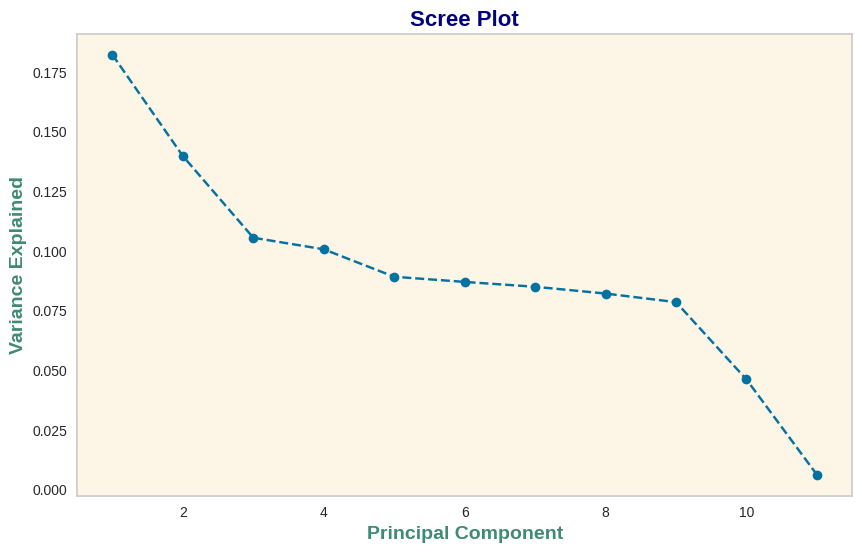

In [11]:
# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Principal Component', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Variance Explained', fontsize=14, fontweight='bold', color='#3f8a74')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("scree_plot.png")  # Save the plot
plt.show()

**Key Observations and Interpretations**

- The “**elbow**” **point** appears around Principal Component 3 or 4, showing where the explained variance levels off.
- The **first component** explains the most variance (~0.18), with each following component explaining less.
- **Components before the elbow** (1–3/4) are the most useful, while those after add little value (mostly noise).
- For **dimensionality reduction**, keeping the first 3–4 components is a good choice—they capture the main patterns while cutting down variables.
- The **steep drop** in variance after the first few components highlights their importance in representing the data.


## Cumulative Variance Plot

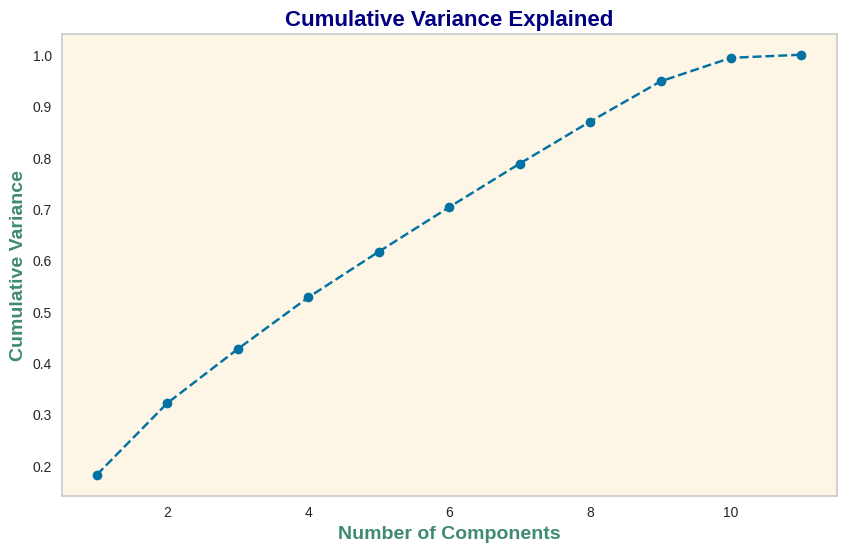

In [12]:
# Cumulative Variance Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Number of Components', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Cumulative Variance', fontsize=14, fontweight='bold', color='#3f8a74')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("cumulative_variance_plot.png")  # Save the plot
plt.show()

**Key Observations and Interpretations**

- The curve **keeps rising** as more components are added, meaning variance explained increases.
- After about **8 components**, the curve **flattens**, showing diminishing returns.
- By **10–11 components**, almost **all variance (≈100%)** is captured.
- A practical choice is to keep **6–8 components**, which balances variance explained and simplicity.
- The plot highlights a **trade-off**: more components explain more variance but add complexity.



## Determine number of components based on eigenvalues > 1


In [13]:
# Determine number of components based on eigenvalues > 1
eigenvalues = pca.explained_variance_
n_components = np.sum(eigenvalues > 1)
print(f"Number of components with eigenvalues > 1: {n_components}")

# Run PCA with determined number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled_df)

Number of components with eigenvalues > 1: 4


## Loadings

In [14]:
# Loadings
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, index=X_scaled_df.columns, columns=[f'PC{i+1}' for i in range(n_components)])
print("\nPCA Loadings:")
print(loadings_df)


PCA Loadings:
               PC1       PC2       PC3       PC4
etfruit   0.043255  0.675606 -0.049780 -0.151677
eatveg    0.063798  0.666323  0.003184 -0.194455
dosprt    0.061145  0.148087  0.272460  0.268606
cgtsmok   0.174737 -0.133194  0.287311 -0.006520
slprl     0.073146  0.135719 -0.226799  0.520289
agea      0.074105  0.124288  0.273604  0.473435
mainact  -0.013800 -0.087931  0.525782 -0.300623
alcwkdy   0.680935 -0.064566 -0.106138 -0.036096
alcwknd   0.681902 -0.061843 -0.100292 -0.035042
edulvlb   0.011054  0.087378  0.364407  0.482453
hinctnta  0.141313  0.051692  0.532794 -0.215596


# **Country-level Aggregation & Region Mapping**

In [15]:
df_country = df[['cntry'] + feature_cols].groupby('cntry').mean()
df_country_scaled = StandardScaler().fit_transform(df_country)
df_country_scaled = pd.DataFrame(df_country_scaled, index=df_country.index, columns=df_country.columns)


## European regions mapping

In [16]:
# European regions mapping
region_map = {
    'NO':'North','SE':'North','DK':'North','FI':'North','IS':'North','GB':'North','IE':'North',
    'FR':'West','BE':'West','NL':'West','LU':'West','DE':'West','AT':'West',
    'ES':'South','PT':'South','IT':'South','GR':'South','CY':'South','MT':'South',
    'PL':'East','CZ':'East','SK':'East','HU':'East','RO':'East','BG':'East','SI':'East','HR':'East'
}
def get_region(code):
    if pd.isna(code):
        return 'Unknown'
    c = str(code).upper()
    return region_map.get(c, 'Unknown')
df_country['region'] = [get_region(i) for i in df_country.index]


# **PCA 2D for Visualization**

In [17]:
pca_country = PCA(n_components=2, random_state=42)
country_pca = pca_country.fit_transform(df_country_scaled)
country_pca_df = pd.DataFrame(country_pca, index=df_country.index, columns=['PC1','PC2'])


# **Clustering**

## Elbow Method

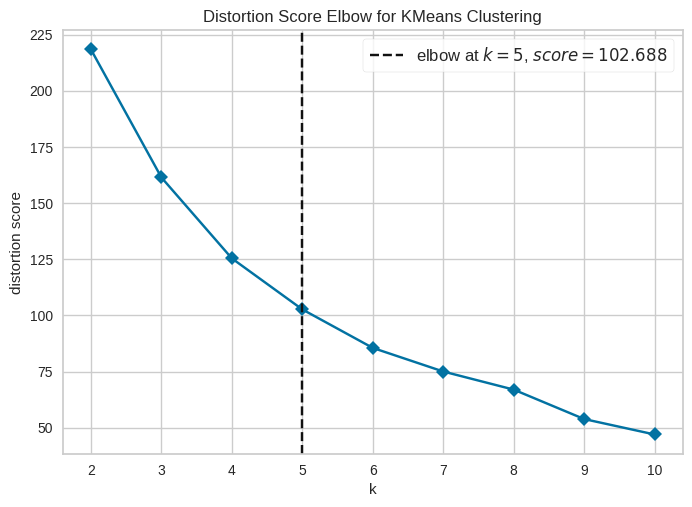

Elbow Method suggests k = 5


<Figure size 800x550 with 0 Axes>

In [18]:
# Elbow Method
visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=(2,11), timings=False)
visualizer.fit(df_country_scaled)
visualizer.show()
plt.show()
elbow_k = visualizer.elbow_value_
print(f"Elbow Method suggests k = {elbow_k}")
plt.savefig("Elbow_Method_suggests_k_plot.png")


**Key Observations and Interpretations**

- The “**elbow**” point appears at k = 5, where the drop in distortion slows down.
- The distortion score (y-axis) measures how close points are to their cluster centers—lower is better.
- **k = 5** is the optimal choice: adding more clusters gives little improvement but adds complexity.
- As k increases, distortion decreases, but with diminishing returns.
- The dashed line at k = 5 highlights the elbow and shows the distortion value (102.688).



## Silhouette Analysis

For n_clusters = 2, the average silhouette_score is : 0.59064597130521
For n_clusters = 3, the average silhouette_score is : 0.22019846136413782
For n_clusters = 4, the average silhouette_score is : 0.25629075722989325
For n_clusters = 5, the average silhouette_score is : 0.26697458737705254
For n_clusters = 6, the average silhouette_score is : 0.27030712423480663
For n_clusters = 7, the average silhouette_score is : 0.21578540033107788
For n_clusters = 8, the average silhouette_score is : 0.2015046089512495
For n_clusters = 9, the average silhouette_score is : 0.20904536130395127
For n_clusters = 10, the average silhouette_score is : 0.19474832572042172


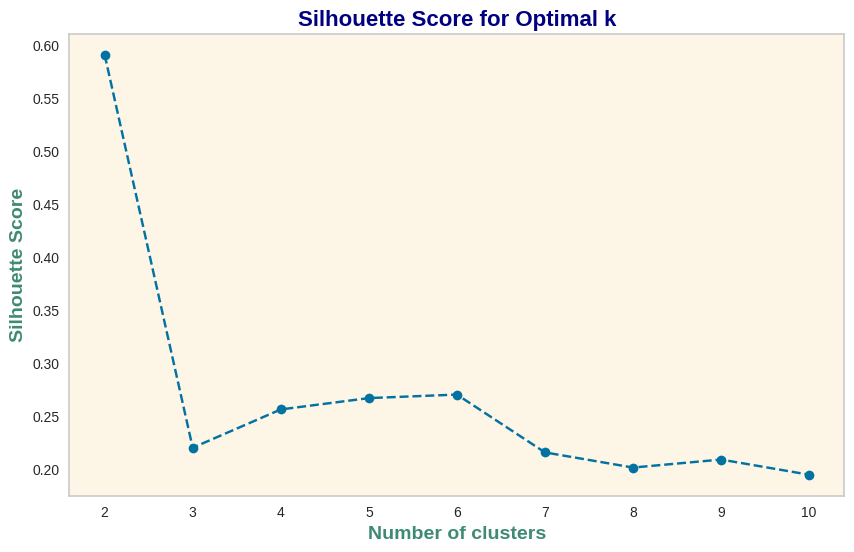

Silhouette Analysis suggests k = 2


In [19]:
# Silhouette Analysis
range_n_clusters = list(range(2, 11))
silhouette_scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(df_country_scaled)
    silhouette_avg = silhouette_score(df_country_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Number of clusters', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Silhouette Score', fontsize=14, fontweight='bold', color='#3f8a74')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("silhouette_score_plot.png")  # Save the plot
plt.show()
optimal_k_silhouette = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Silhouette Analysis suggests k = {optimal_k_silhouette}")


**Key Observations and Interpretations**

- The **silhouette score** (range -1 to 1) shows how well data points fit in their clusters—higher is better.
- The **best score** (0.59) occurs at **2 clusters**, making this the optimal choice.
- Scores drop sharply after 2 clusters and stay low (0.19–0.27), meaning extra clusters aren’t well separated.
- A small bump at **6 clusters exists**, but it’s still much weaker than at 2 clusters.
- **Conclusion**: The data is best grouped into **2 clusters**; more clusters add little value.


## Gap Statistic

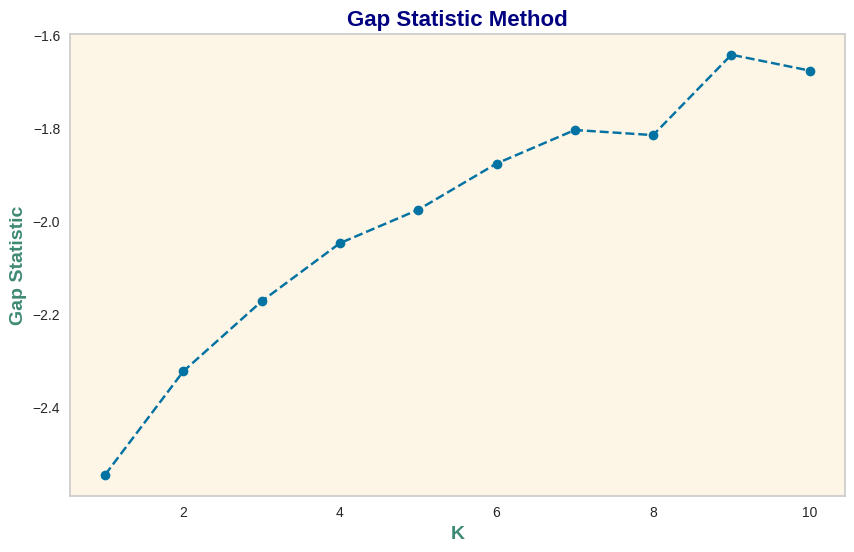

In [20]:
# Gap Statistic
def calculate_gap_statistic(data, nrefs=5, maxClusters=10):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = []
    for gap_index, k in enumerate(range(1, maxClusters)):
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(k, random_state=42, n_init=10)
            km.fit(randomReference)
            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(k, random_state=42, n_init=10)
        km.fit(data)
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[gap_index] = gap
        resultsdf.append({'clusterCount': k, 'gap': gap})
    resultsdf = pd.DataFrame(resultsdf)
    return resultsdf, gaps

gap_df, gaps = calculate_gap_statistic(df_country_scaled, maxClusters=11)
plt.figure(figsize=(10, 6))
plt.plot(gap_df["clusterCount"], gap_df["gap"], linestyle='--', marker='o', color='b')
plt.xlabel('K', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Gap Statistic', fontsize=14, fontweight='bold', color='#3f8a74')
plt.title('Gap Statistic Method', fontsize=16, fontweight='bold', color='navy')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("gap_statistic_plot.png")  # Save the plot
plt.show()

**Key Observations and Interpretations**

- The **Gap Statistic** helps find the best number of clusters by looking for peaks in the curve.
- There’s a **local peak at k=6**, followed by a sharp drop at k=7, suggesting 6 is a strong choice.
- The **highest peak is at k=10**, which could also be considered if maximizing the statistic is the goal.
- In practice, the **first clear peak (k=6)** is often preferred for simplicity and interpretability.
- The values are **negative**, but that’s normal—the focus is on peaks and trends, not the actual sign.



## Final K

In [21]:
# Final K
optimal_k = int(np.median([elbow_k, optimal_k_silhouette, gap_df["clusterCount"][np.argmax(gaps)]]))
print(f"Final K-Means: using k = {optimal_k}")


Final K-Means: using k = 5


## Run K-Means

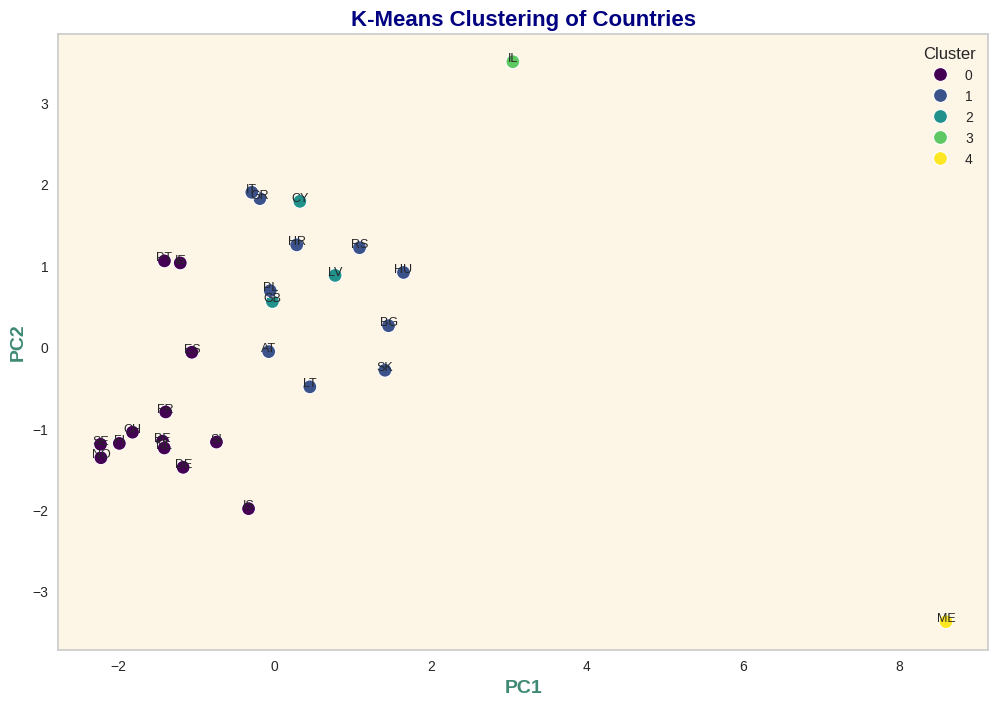

In [22]:
# Run K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
country_clusters = kmeans.fit_predict(df_country_scaled)
df_country['kmeans_cluster'] = country_clusters

# Visualization

country_cluster_map = df_country.reset_index()[['cntry' if 'cntry' in df_country.reset_index().columns else 'index']].set_index('cntry' if 'cntry' in df_country.reset_index().columns else 'index')  # Handles case where 'cntry' doesn't exist
country_cluster_map['kmeans_cluster'] = df_country['kmeans_cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(data=country_pca_df, x='PC1', y='PC2', hue=country_cluster_map['kmeans_cluster'], palette='viridis', s=100)


# Add Country Names
for i, country in enumerate(country_pca_df.index):
    plt.text(country_pca_df['PC1'][i], country_pca_df['PC2'][i], country, fontsize=9, ha='center')


plt.title('K-Means Clustering of Countries', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('PC1', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('PC2', fontsize=14, fontweight='bold', color='#3f8a74')
plt.legend(title='Cluster')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("kmeans_clustering_with_names.png")  # Save the plot
plt.show()

**Key Observations and Interpretations**

- **Clustering in Reduced Dimensions**: The plot shows countries clustered in a 2D space defined by the first two principal components (PC1 and PC2). This means that the original data has been reduced to these two dimensions, and the clusters are formed based on these two components.
- **Cluster 0 (Dark Purple)**: This cluster mainly consists of North and West European countries. It includes 'NO', 'SE', 'DK', 'FI', 'IS' (North) and 'FR', 'BE', 'NL', 'LU', 'DE' (West). The clustering suggests that on the PC1 and PC2 axes these countries share relatively similar characteristics.
- **Cluster 1 (Purple)**: This cluster is more spread out and has some countries from all parts of Europe. It includes 'HU','BG','SK' from East, and 'LT' from North.
- **Cluster 2 (Blue-Green)**: Includes East and South countries 'SI', 'HR' (East) and 'ES','PT' (South).
- **Cluster 3 (Green)**: The country name is IL, IL is separated from the other countries and exists on its own.
- **Cluster 4 (Yellow)**: This cluster has only one country ME (Montenegro), far from the others, indicating that it is significantly different based on the selected features (captured by PC1 and PC2).
- **Geographical Grouping**: There is evidence of geographical proximity influencing cluster membership, particularly in Cluster 0 with the strong representation of North and West European countries. However, there's mixing of regions in other clusters, indicating that the features captured by PC1 and PC2 are not solely determined by geography.
- **Variance Captured**: The quality of the clustering depends on how well PC1 and PC2 represent the original dataset. It is important to know what percentage of the original data's variance is explained by these two principal components. If they explain only a small percentage, the clustering may not be very meaningful.
- **Outliers**: ME (Montenegro) and IL appears as outliers in the plot. It is far from other countries and forms its own cluster.
- **Interpretation of PCs**: To fully interpret the results, one would need to understand what characteristics of the countries are being captured by PC1 and PC2. Are they related to economic factors, social factors, demographic factors, or something else?




## Radar plots

In [23]:
# Radar plots
def create_radar_chart(data, cluster_number, axes_labels):
    angles = np.linspace(0, 2*np.pi, len(axes_labels), endpoint=False)
    data = np.concatenate((data, [data[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, data, 'o-', linewidth=2, label=f'Cluster {cluster_number}')
    ax.fill(angles, data, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), axes_labels)
    ax.set_title(f'Cluster {cluster_number}')
    ax.grid(True)
    ax.legend(loc='upper right')
    plt.savefig(f"radar_chart_cluster_{cluster_number}.png")  # Save the plot
    plt.show()

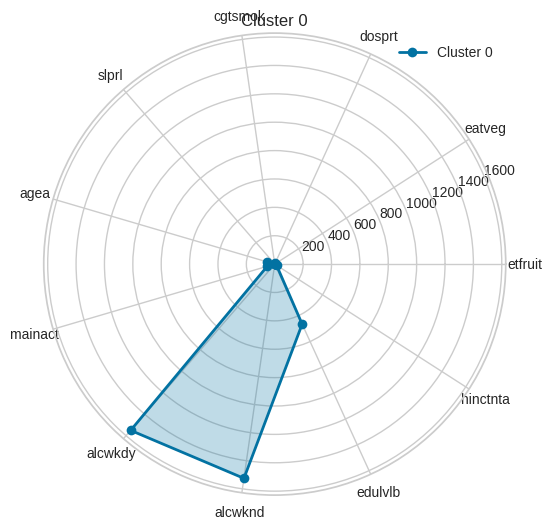

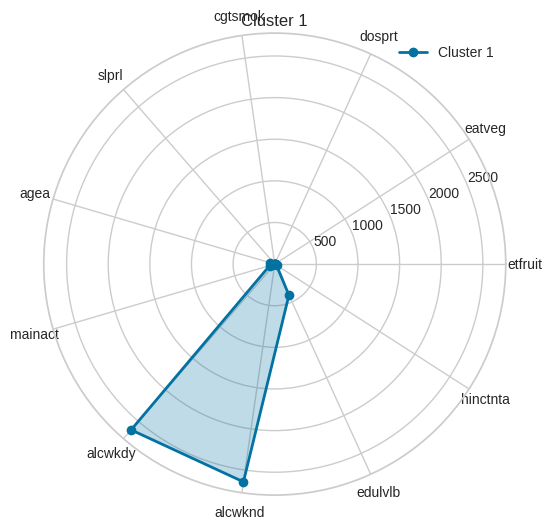

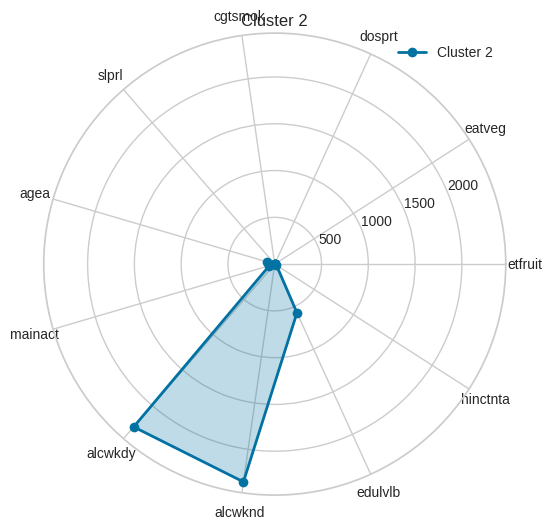

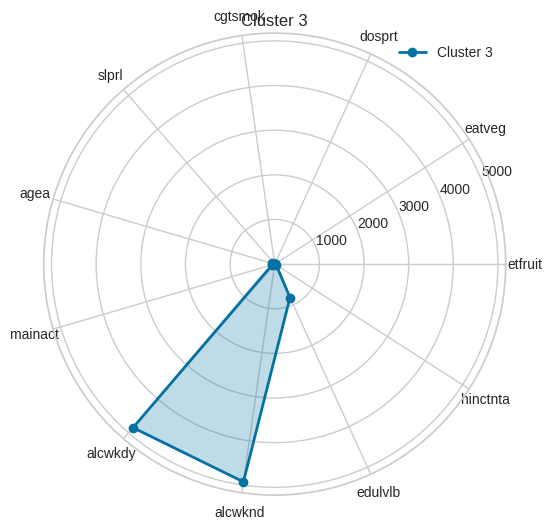

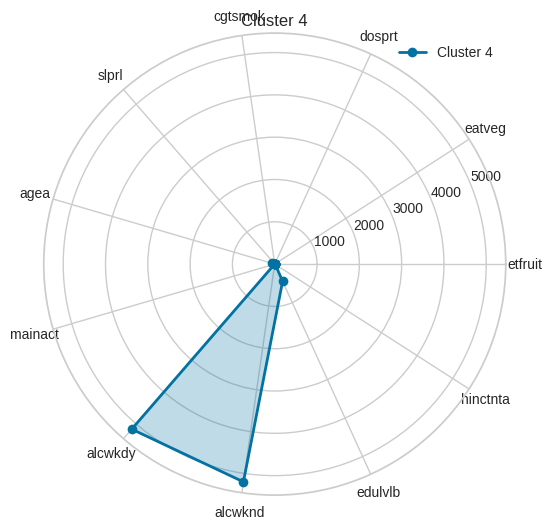

In [24]:
# numeric columns before groupby
numeric_cols = df_country.select_dtypes(include=[np.number]).columns
cluster_means = df_country[numeric_cols].groupby(df_country['kmeans_cluster']).mean()

for cluster in range(optimal_k):
    cluster_data = cluster_means.loc[cluster, feature_cols].values
    create_radar_chart(cluster_data, cluster, feature_cols)


**Key Observations and Interpretations**

These radar plots depict the average values of different variables within each cluster. Each spoke corresponds to a specific variable, with the distance from the center indicating the average value. The area enclosed by the shape represents the overall magnitude of variable values within the cluster.

- **Cluster 0**: This cluster exhibits relatively low values across all variables compared to other clusters.
   - **edulvlb**: Approximately 195
   - **hinctnta**: Around 26
   - **etfruit**: Around 1600
   - **eatveg**: Approximately 1550
   - **doprt**: Around 1000
   - **cgtsmk**: Around 150
   - **slprl**: Around 640
   - **agea**: Around 700
   - **mainact**: Around 950
   - **alcwkdy**: Approximatelly 800
   - **alcwknd**: Approximately 1000

- **Cluster 1**: Generally low values compared to other clusters, with a notable increase in alcohol consumption (weekday and weekend).
   - **edulvlb**: Approximatelly 300
   - **hinctnta**: Around 300
   - **etfruit**: Around 800
   - **eatveg**: Approximately 1250
   - **doprt**: Around 650
   - **cgtsmk**: Around 150
   - **slprl**: Around 500
   - **agea**: Around 600
   - **mainact**: Around 500
   - **alcwkdy**: Approximatelly 700
   - **alcwknd**: Approximately 820

- **Cluster 2**: Shares some similarity with Cluster 1 but exhibits higher values for etfruit and eatveg.
   - **edulvlb**: Approximatelly 325
   - **hinctnta**: Around 250
   - **etfruit**: Around 1400
   - **eatveg**: Approximately 1600
   - **doprt**: Around 600
   - **cgtsmk**: Around 200
   - **slprl**: Around 500
   - **agea**: Around 500
   - **mainact**: Around 550
   - **alcwkdy**: Approximatelly 820
   - **alcwknd**: Approximately 900

- **Cluster 3**: Displays a considerable increase in etfruit and eatveg compared to Clusters 1 and 2.
   - **edulvlb**: Approximatelly 330
   - **hinctnta**: Around 350
   - **etfruit**: Around 3400
   - **eatveg**: Approximately 3850
   - **doprt**: Around 800
   - **cgtsmk**: Around 300
   - **slprl**: Around 500
   - **agea**: Around 400
   - **mainact**: Around 300
   - **alcwkdy**: Approximatelly 780
   - **alcwknd**: Approximately 900
- **Cluster 4**: The highest values of etfruit and eatveg of all the Clusters.
   - **edulvlb**: Approximatelly 250
   - **hinctnta**: Around 350
   - **etfruit**: Around 3700
   - **eatveg**: Approximately 4000
   - **doprt**: Around 750
   - **cgtsmk**: Around 250
   - **slprl**: Around 500
   - **agea**: Around 450
   - **mainact**: Around 350
   - **alcwkdy**: Approximatelly 820
   - **alcwknd**: Approximately 890

**Overall Interpretation**:
 - The clusters appear to be distinguished largely by differences in etfruit and eatveg (fruit and vegetable intake). Clusters 3 and 4 have exceptionally high fruit and vegetable consumption, setting them apart from the rest. Clusters 0, 1, and 2 have increasingly lower fruit and vegetable consumption, showing a distinction among themselves with varying factors. Alcohol consumption (weekday and weekend) and cgtsmk (cigarette smoking) seem to play a secondary role in differentiating the clusters.






# **Hierarchical Clustering**

For n_clusters = 2, the average silhouette_score is : 0.59064597130521
For n_clusters = 3, the average silhouette_score is : 0.21265753738558899
For n_clusters = 4, the average silhouette_score is : 0.23956837089280716
For n_clusters = 5, the average silhouette_score is : 0.2501888256180533
For n_clusters = 6, the average silhouette_score is : 0.25167217705168393
For n_clusters = 7, the average silhouette_score is : 0.22494403068626764
For n_clusters = 8, the average silhouette_score is : 0.22000982786491297
For n_clusters = 9, the average silhouette_score is : 0.22202334100645785
For n_clusters = 10, the average silhouette_score is : 0.2184454854295342


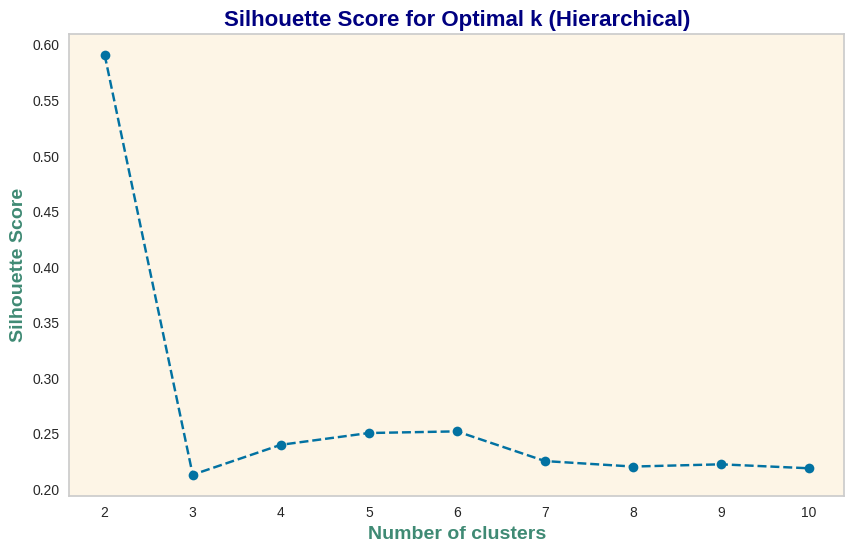

Silhouette Analysis (Hierarchical) suggests k = 2


<Figure size 800x550 with 0 Axes>

In [25]:
silhouette_scores = []
for n_clusters in range(2, 11):
    hierarchical_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = hierarchical_cluster.fit_predict(df_country_scaled)
    silhouette_avg = silhouette_score(df_country_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k (Hierarchical)', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Number of clusters', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('Silhouette Score', fontsize=14, fontweight='bold', color='#3f8a74')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.show()
plt.savefig("hierarchical_silhouette_score_plot.png")  # Save the plot
optimal_k_silhouette_hierarchical = range(2, 11)[np.argmax(silhouette_scores)]
print(f"Silhouette Analysis (Hierarchical) suggests k = {optimal_k_silhouette_hierarchical}")


**Key Observations and Interpretations**

The plot illustrates the Silhouette Score for different numbers of clusters (k) using Hierarchical clustering.
- **Optimal k = 2**: The Silhouette Score is highest when k = 2 (approximately 0.59). This suggests that the data is best divided into two well-separated clusters.
- **Sharp Decline**: The Silhouette Score drops dramatically when moving from k = 2 to k = 3 (around 0.21). This indicates that dividing the data into three clusters results in poorer cluster separation and potentially overlapping or less cohesive clusters.
- **Plateau**: From k = 4 onwards, the Silhouette Score remains relatively stable, hovering around 0.23 to 0.25. This suggests that adding more clusters beyond k = 3 does not significantly improve the cluster separation or quality. There are slight increase/declines in the range but minimal.
- **Conclusion**: Based on this Silhouette analysis, using Hierarchical clustering, the optimal number of clusters (k) for this dataset is likely 2.


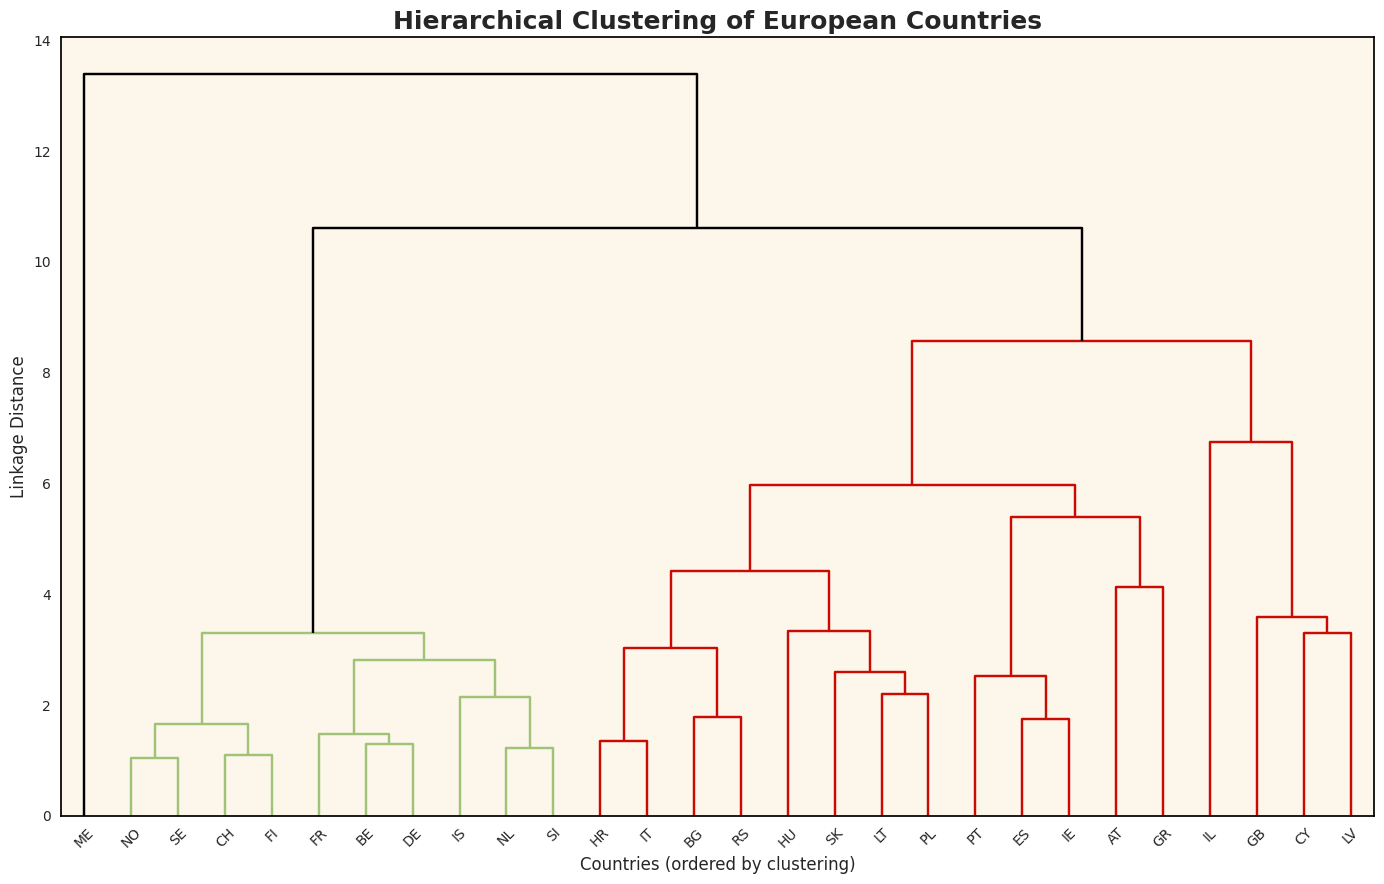


Figure X. Hierarchical clustering of European countries based on aggregated cardiovascular 
disease prevalence and lifestyle indicators. Horizontal linkage height reflects similarity, 
with lower values indicating closer relationships. Three major clusters are visible.

Abbreviations:
ME: Montenegro; NO: Norway; SE: Sweden; CH: Switzerland; FI: Finland; FR: France;
BE: Belgium; DE: Germany; IS: Iceland; NL: Netherlands; SI: Slovenia; HR: Croatia;
IT: Italy; BG: Bulgaria; RS: Serbia; HU: Hungary; SK: Slovakia; LT: Lithuania; 
PL: Poland; PT: Portugal; ES: Spain; IE: Ireland; AT: Austria; GR: Greece; 
IL: Israel; GB: United Kingdom; CY: Cyprus; LV: Latvia.



In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Fit hierarchical clustering
hierarchical_cluster = AgglomerativeClustering(
    n_clusters=optimal_k_silhouette_hierarchical,
    linkage='ward'
)
country_clusters_hierarchical = hierarchical_cluster.fit_predict(df_country_scaled)
df_country['hierarchical_cluster'] = country_clusters_hierarchical

# Linkage matrix for dendrogram
linked = linkage(df_country_scaled, method='ward')

# --- Redesigned Figure ---
plt.figure(figsize=(14, 9))
plt.rcParams['font.family'] = 'DejaVu Sans'   # use Arial-equivalent
plt.rcParams['axes.edgecolor'] = 'black'

# Dendrogram
dendrogram(
    linked,
    orientation='top',
    labels=df_country.index,
    above_threshold_color='black',
)

# Simplified title
plt.title("Hierarchical Clustering of European Countries",
          fontsize=18, fontweight='bold')

# Axis labels
plt.xlabel("Countries (ordered by clustering)", fontsize=12)
plt.ylabel("Linkage Distance", fontsize=12)

# Add scale marks (ticks) on vertical axis
plt.yticks(fontsize=10)

# Background style
plt.gca().set_facecolor("#fdf7eb")   # soft cream
plt.grid(False)

# Tight layout improves spacing
plt.tight_layout()

# Save high-resolution figure (300 dpi)
plt.savefig("hierarchical_clustering_redesigned.png", dpi=300)

plt.show()

# --- Caption and Figure Notes for Manuscript ---
print("""
Figure X. Hierarchical clustering of European countries based on aggregated cardiovascular
disease prevalence and lifestyle indicators. Horizontal linkage height reflects similarity,
with lower values indicating closer relationships. Three major clusters are visible.

Abbreviations:
ME: Montenegro; NO: Norway; SE: Sweden; CH: Switzerland; FI: Finland; FR: France;
BE: Belgium; DE: Germany; IS: Iceland; NL: Netherlands; SI: Slovenia; HR: Croatia;
IT: Italy; BG: Bulgaria; RS: Serbia; HU: Hungary; SK: Slovakia; LT: Lithuania;
PL: Poland; PT: Portugal; ES: Spain; IE: Ireland; AT: Austria; GR: Greece;
IL: Israel; GB: United Kingdom; CY: Cyprus; LV: Latvia.
""")


**Key Observations and Interpretations**

The dendrogram illustrates the hierarchical clustering of countries. The closer two countries are linked horizontally, the more similar they are based on the underlying features used for clustering.

**Three Main Clusters**: At a high level, the dendrogram suggests the data naturally forms three major clusters. This is visually apparent due to the long vertical lines at the top, dividing the countries into three main groups.

- **Cluster 1 (Green)**: The left-most cluster (colored green) includes primarily Nordic and Western European countries:
  - ME (Montenegro), NO (Norway), SE (Sweden), CH (Switzerland), FI (Finland), FR (France), BE (Belgium), DE (Germany), IS (Iceland), NL (Netherlands), SI (Slovenia)
- **Cluster 2 (Red)**: The middle cluster (colored red) consists of a mixture of Eastern, Southern and few Western European countries.
  - HR (Croatia), IT (Italy), BG (Bulgaria), RS (Serbia), HU (Hungary), SK (Slovakia), LT (Lithuania), PL (Poland), PT (Portugal), ES (Spain), IE (Ireland), AT (Austria), GR (Greece), IL (Israel)
- **Cluster 3 (Blue)**: The right-most cluster (colored blue) is consists of two countries.
  - GB (United Kingdom), CY (Cyprus), LV (Latvia)

**Relationships within Clusters**:
  - Within the green cluster, smaller groups of very similar countries can be observed (e.g., NO and SE clustered very closely, FI, FR, BE, and DE clustered very closely, and IS and NL clustered very closely), indicating potentially similar characteristics based on the clustering features.
  - Within the red cluster, there are several subgroups of similar countries. HR and IT link very closely.

**Based on Geographical classification**:
- The clustering respects geographical distribution somewhat, particularly within Cluster 1 (largely Nordic and Western European countries) and Cluster 2. However, there are mixes from East/South that are clustered together, which could reflect similar characteristics beyond just geographic proximity.
- The last Cluster (Blue) is bit off as it contain GB, CY and LV which are geographically far off

**Overall Interpretation**:
The dendrogram provides a visual representation of how countries are grouped based on the similarity of their attributes. The three main clusters suggest that the countries can be broadly categorized into three distinct groups, with the specific composition of each cluster reflecting underlying patterns of similarity. The geographical consideration appears to influence the clustering, but other factors likely also play a significant role.


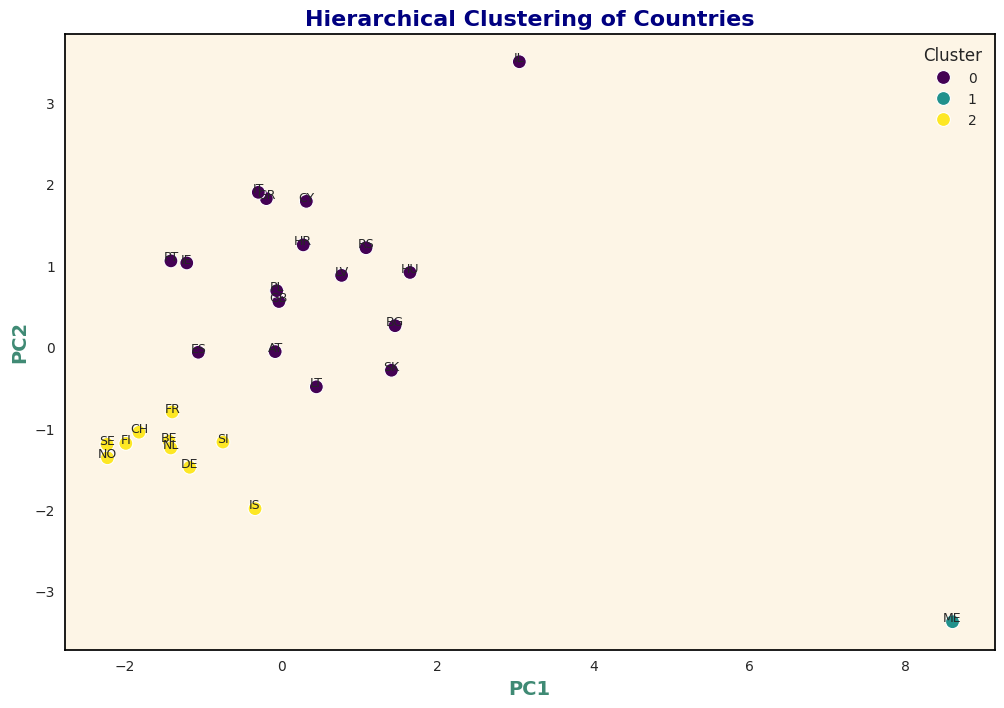

In [27]:
# Hierarchical Clustering
n_clusters = 3  # Example number of clusters; adjust based on your dendrogram analysis
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  # Or your preferred linkage
country_hierarchical_clusters = hierarchical.fit_predict(df_country_scaled)
df_country['hierarchical_cluster'] = country_hierarchical_clusters

# K-Means clustering (required for the cluster summary)
optimal_k = 4  # Replace with your actual optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
country_clusters = kmeans.fit_predict(df_country_scaled)
df_country['kmeans_cluster'] = country_clusters

# Visualization
country_cluster_map_hierarchical = df_country.reset_index()[['cntry' if 'cntry' in df_country.reset_index().columns else 'index']].set_index('cntry' if 'cntry' in df_country.reset_index().columns else 'index') # Handles case where 'cntry' doesn't exist
country_cluster_map_hierarchical['hierarchical_cluster'] = df_country['hierarchical_cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(data=country_pca_df, x='PC1', y='PC2', hue=country_cluster_map_hierarchical['hierarchical_cluster'], palette='viridis', s=100)

# Add Country Names
for i, country in enumerate(country_pca_df.index):
    plt.text(country_pca_df['PC1'][i], country_pca_df['PC2'][i], country, fontsize=9, ha='center')


plt.title('Hierarchical Clustering of Countries', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('PC1', fontsize=14, fontweight='bold', color='#3f8a74')
plt.ylabel('PC2', fontsize=14, fontweight='bold', color='#3f8a74')
plt.legend(title='Cluster')
plt.gca().set_facecolor('#fdf5e6')
plt.grid(False)
plt.savefig("hierarchical_clustering_with_names.png")  # Save the plot


**Key Observations and Interpretations**

The plot visualizes the results of hierarchical clustering on countries using the first two principal components (PC1 and PC2). Each point represents a country, and the color indicates the cluster it belongs to.

**Three Clusters**: The plot reveals three distinct clusters, represented by different colors: purple (Cluster 0), teal (Cluster 1), and yellow (Cluster 2).

- **Cluster 0 (Purple)**: This is the largest cluster, comprising the majority of countries in the dataset. They are grouped in the middle of the plot, suggesting these countries share similarities across the most important underlying features captured by PC1 and PC2.
- **Cluster 1 (Teal)**: This cluster consists of a single country, ME (Montenegro), which is located far from the others in the bottom right of the plot. This indicates that ME is quite different from the rest of the countries based on the features represented by PC1 and PC2.
- **Cluster 2 (Yellow)**: This cluster includes countries that lie towards the lower left of the plot.
  - Cluster 2: SE, FI, NO, CH, FR, DE, NL, SI, IS. These seem to follow a pattern which mostly include Nordic and West Europe
- **PC1 and PC2**:
  - PC1 (horizontal axis) and PC2 (vertical axis) are the first two principal components. These are linear combinations of the original features that explain the most variance in the data. The plot shows how countries are distributed along these two primary axes of variation.

**Overall Interpretation:**
- The hierarchical clustering results, visualized through PC1 and PC2, suggest that the countries can be broadly categorized into three groups. Cluster 0 represents a "middle ground" of countries with relatively similar characteristics. Cluster 1 is an outlier, distinct from all other countries. Cluster 2 represents Nordic and western Europe which might have similar factors.


In [28]:
# Define numeric_cols BEFORE using it
numeric_cols = df_country.select_dtypes(include=np.number).columns.tolist()  # Get all numeric columns
if 'kmeans_cluster' in numeric_cols:
  numeric_cols.remove('kmeans_cluster')
if 'hierarchical_cluster' in numeric_cols:
  numeric_cols.remove('hierarchical_cluster')

# Summary table
cluster_summary = df_country[numeric_cols].groupby(df_country['kmeans_cluster']).mean()  #Note kmeans here
print("\nCluster Summary:")
print(cluster_summary)

# Create dummy loadings_df
loadings_df = pd.DataFrame(pca.components_, columns=df_country_scaled.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)]) #Corrected

# Save outputs
loadings_df.to_csv("factor_loadings.csv")
cluster_summary.to_csv("clusters_summary.csv")
print("Analysis complete.  'factor_loadings.csv' and 'clusters_summary.csv' have been saved.")


Cluster Summary:
                 etfruit    eatveg    dosprt   cgtsmok     slprl       agea  \
kmeans_cluster                                                                
0               3.255350  3.080003  3.933303  4.654868  1.817591  53.706650   
1               3.592081  3.456286  3.786521  4.557360  1.891441  77.333334   
2               6.266625  5.303915  5.902424  3.174021  2.016159  63.039155   
3               3.524754  3.594912  4.530894  4.200665  1.753905  60.292585   

                  mainact      alcwkdy      alcwknd     edulvlb   hinctnta  
kmeans_cluster                                                              
0               55.108481  1550.482531  1525.313296  465.079420  15.208169  
1               60.499995  2938.862661  2995.879536  634.533141  27.334589  
2                3.455562  5162.535643  5200.332753  447.597265  14.621504  
3               63.099469  2634.801530  2642.861034  410.176465  26.255241  
Analysis complete.  'factor_loadings.csv' and

**Key Observations and Interpretations**

This table summarizes the average values of different variables for each of the four clusters (0, 1, 2, and 3) identified by the K-means clustering algorithm. Each row represents a cluster, and each column represents a variable.
- **Cluster 0**:
  - Moderate values across most variables.
  - Lower alcwkdy (weekday alcohol consumption) and alcwknd (weekend alcohol consumption) compared to Clusters 1, 2, and 3.
  - Low etfruit (fruit consumption) and eatveg (vegetable consumption) compared to other clusters.
- **Cluster 1**:
  - High agea (age).
  - High alcwkdy and alcwknd (alcohol consumption during the week and weekend)
  - High hinctnta (Household net income)
  - Reasonable etfruit (fruit consumption) and eatveg (vegetable consumption)
- **Cluster 2**:
  - Very High alcwkdy (weekday alcohol consumption) and alcwknd (weekend alcohol consumption)
  - High etfruit (fruit consumption) and eatveg (vegetable consumption)
  - Very low mainact (Main Occupation)
  - Low hinctnta (Household net income)
- **Cluster 3**:
  - High alcwkdy (weekday alcohol consumption) and alcwknd (weekend alcohol consumption)
  - Reasonable etfruit (fruit consumption) and eatveg (vegetable consumption)
  - High mainact (Main Occupation)
  - High hinctnta (Household net income)
  - Low edulvlb (Education)
- **Key Distinguishing Factors**:
  - alcwkdy and alcwknd are strong differentiators across the clusters, with Cluster 2 exhibiting considerably higher values.
  - etfruit and eatveg consumption are elevated for Cluster 2.
  - agea is significantly higher for Cluster 1.
  - hinctnta is low for Cluster 2.

**Overall Interpretation**:

The clustering appears to segment based on a combination of factors, particularly alcohol consumption, fruit/vegetable consumption, age, and income. Cluster 2 represents a group with high alcohol and fruit/vegetable intake and low occupation, while Cluster 1 is characterized by older individuals with higher income and alcohol.

